In [1]:
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow import keras
import os
import re
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.pipeline import TransformerMixin
from sklearn.base import BaseEstimator
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Embedding, LSTM
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import Constant

from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.preprocessing import sequence
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from sklearn.model_selection import train_test_split

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
!unzip /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora/

Archive:  /usr/share/nltk_data/corpora/wordnet.zip
   creating: /usr/share/nltk_data/corpora/wordnet/
  inflating: /usr/share/nltk_data/corpora/wordnet/lexnames  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adv  
  inflating: /usr/share/nltk_data/corpora/wordnet/adv.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.verb  
  inflating: /usr/share/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /usr/share/nltk_data/corpora/wordnet/data.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.adj  
  inflating: /usr/share/nltk_data/corpora/wordnet/LICENSE  
  inflating: /usr/share/nltk_data/corpora/wordnet/citation.bib  
  inflating: /usr/share/nltk_data/corpora/wordnet/noun.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/verb.exc  
  inflating: /usr/share/nltk_data/corpora/wordnet/README  
  inflating: /usr/share/nltk_data/corpora/wordnet/index.sense  
  inflating: /usr/share/nltk_data

In [3]:
#função pra ajudar a fazer o pré-processamento dos dados
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.io.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Junta os positivos e negativos e da um shuffle neles
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

In [4]:
#aqui vai ter que ajustar pra rodar
train = load_dataset('/kaggle/input/imdb-review/aclImdb/train')
test = load_dataset('/kaggle/input/imdb-review/aclImdb/test')
train = train.append(test[:len(test)//2], ignore_index=True)
test = test[len(test)//2:]
test = test.reset_index()

In [6]:
train.head()

,sentence,sentiment,polarity
0,I think this is probably one of the worst movi...,1,0
1,I felt Rancid Aluminium was a complete waste o...,1,0
2,An unusual film from Ringo Lam and one that's ...,8,1
3,Perhaps Disney was hoping for another Mary Pop...,7,1
4,I came at this film with high expectations. I ...,1,0


In [7]:
test.head()

,index,sentence,sentiment,polarity
0,12500,"wow, i just got one watching this.<br /><br />...",2,0
1,12501,this movie is about people living at a trailer...,4,0
2,12502,HANA-BI has many quiet moments and fairly slow...,4,0
3,12503,This one's as cheesy as they come  the concep...,3,0
4,12504,This is definitely one of the better Mel Brook...,7,1


In [8]:
# Função para pré-processar os textos
def preprocess_text(text):
    # Converter para minúsculas
    text = text.lower()
    
    # Remover tags HTML (se houver)
    text = re.sub('<[^>]+>', '', text)
    
    # Remover pontuações e caracteres especiais
    text = re.sub('[^a-zA-Z0-9]', ' ', text)
    
    # Remover espaços extras
    text = re.sub('\s+', ' ', text)
    
    # Remover stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)
    
    # Lemmatização
    lemmatizer = WordNetLemmatizer()
    text = ' '.join(lemmatizer.lemmatize(word) for word in text.split())
    
    return text

In [9]:
# Dividir os dados em treinamento e teste
texts_train = train.loc[:, "sentence"]
labels_train = train.loc[:, "polarity"]

texts_test = test.loc[:, "sentence"]
labels_test =  test.loc[:, "polarity"]

# Aplicar o pré-processamento nos textos
texts_train = texts_train.apply(preprocess_text)
texts_test = texts_test.apply(preprocess_text)

# Tokenizar os textos
max_words = 1000
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts_train)

# Transformar os textos em sequências numéricas
sequences_train = tokenizer.texts_to_sequences(texts_train)
sequences_test = tokenizer.texts_to_sequences(texts_test)

# Padronizar o comprimento das sequências
max_review_length = 500
X_train = pad_sequences(sequences_train, maxlen=max_review_length)
X_test = pad_sequences(sequences_test, maxlen=max_review_length)

# Codificar os rótulos utilizando one-hot encoding
num_classes = len(np.unique(labels_train))
y_train = np.eye(num_classes)[labels_train]
y_test = np.eye(num_classes)[labels_test]


In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Conv1D, MaxPooling1D, Dense, Dropout, GlobalMaxPooling1D

# Construir o modelo LSTM-CNN
model = Sequential()
model.add(Embedding(max_words, 64, input_length=max_review_length))
model.add(Dropout(0.8))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(num_classes, activation='sigmoid'))

# Compilar o modelo
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treinar o modelo
# model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=64)

Epoch 1/20
74/74 [==============================] - 7s 60ms/step - loss: 0.5742 - accuracy: 0.6737 - val_loss: 0.3771 - val_accuracy: 0.8381
Epoch 2/20
74/74 [==============================] - 4s 48ms/step - loss: 0.3631 - accuracy: 0.8407 - val_loss: 0.3249 - val_accuracy: 0.8646
Epoch 3/20
74/74 [==============================] - 4s 52ms/step - loss: 0.3362 - accuracy: 0.8558 - val_loss: 0.3169 - val_accuracy: 0.8629
Epoch 4/20
74/74 [==============================] - 3s 45ms/step - loss: 0.3252 - accuracy: 0.8605 - val_loss: 0.3073 - val_accuracy: 0.8658
Epoch 5/20
74/74 [==============================] - 3s 46ms/step - loss: 0.3223 - accuracy: 0.8599 - val_loss: 0.3018 - val_accuracy: 0.8707
Epoch 6/20
74/74 [==============================] - 4s 52ms/step - loss: 0.3148 - accuracy: 0.8641 - val_loss: 0.3042 - val_accuracy: 0.8674
Epoch 7/20
74/74 [==============================] - 4s 49ms/step - loss: 0.3117 - accuracy: 0.8655 - val_loss: 0.3083 - val_accuracy: 0.8665
Epoch 8/20
74

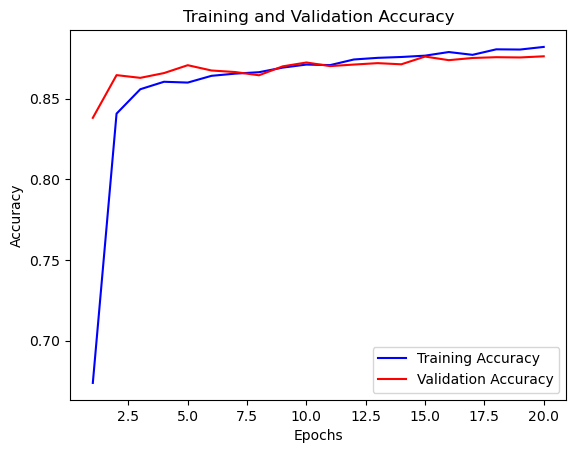

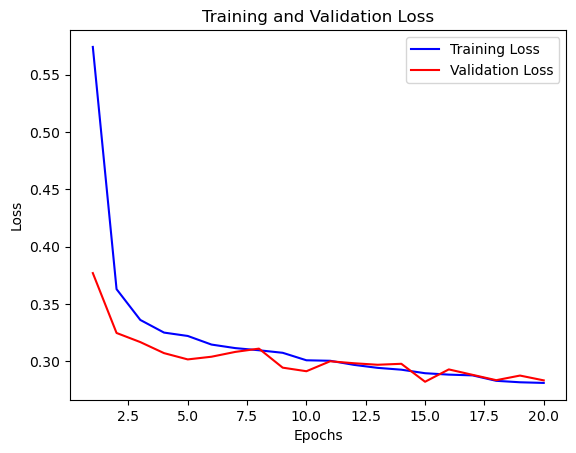

In [19]:
import matplotlib.pyplot as plt

# Treinar o modelo e acompanhar a acurácia durante as épocas
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=512)

# Obter as métricas de acurácia durante o treinamento
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(1, len(train_acc) + 1)

# Plotar o gráfico de acurácia
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



# Obter as métricas de acurácia durante o treinamento
train_lss = history.history['loss']
val_lss = history.history['val_loss']
epochs = range(1, len(train_lss) + 1)

# Plotar o gráfico de loss
plt.plot(epochs, train_lss, 'b-', label='Training Loss')
plt.plot(epochs, val_lss, 'r-', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()